# Protein BERT Starter Notebook - LB 0.30
This notebook demonstrates how to finetune an NLP transformer to compete in Kaggle's Novozymes Enzyme Stability Prediction competition. We train with Jin's external data described [here][2] which uses delta `Tm` and delta `dG` targets. How to train with `dTm` target instead of `Tm` target is explained [here][4]. We use the PyTorch pipeline from Y.Nakama's starter NLP notebook from Feedback Prize 3 competition [here][1]. We will finetune HuggingFace's pretrained `Rostlab/prot_bert` model.

The competition FP3 is a regression NLP task. Our competition NESP is also a regression task and we can treat protein amino acid sequences as "sentences" where each amino acid is a "word". 

The secret ingredient for success is the architecture of our model. In FP3 we feed one sentence and get one regression. In NESP, we must feed two "sentences". We input both the wild type sequence and mutant sequence into our model. Then we subtract the embeddings and concatenate that result with the wild type and mutant embeddings. We do this both with the specific mutant amino acid token output embedding, and the entire sequences embedding after mean pooling. Finally we use a dense layer to predict one regression target. See diagram below and review code in code cell 23.

![](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/Oct-2022/prot_bert.png)

Furthermore, we freeze 22 out of the 30 blocks of Protein BERT to retain most of Protein BERT original pretraining knowledge which improves CV LB. By modifying the architecture, freezing, training schedule, and other hyperparameters, it is possible to improve this notebook's CV LB. Also we can use different train data like FireProtDB [here][6]. Or we can use Vladimir's large mutation dataset [here][9]. Also we can try using different pretrained transformers besides `Rostlab/prot_bert` like Facebooks's ESM or MSA [here][5]. This notebook trains 3 out of 5 folds. Using more folds improves CV LB. Note version 4+ use ESM2 transformer.

Currently we are using Kaggle's new 1xT4 GPU instead of 1xP100 GPU. This gives us 1.6x speed up. This is because T4 GPU can utilize mixed precision better than P100 GPU. **UPDATE:** CPMP got 2xT4 to work! He published a notebook [here][7]. This gives approximately another 2x speed up (for total of 3x speed up wow!) if we increase batch size too. 

Note my version 4 had a variable error (code worked correctly) (it was regarding freezing and unfreezing ESM2 layers/blocks) which is also in CPMP's version 1 and 2. My version 5 corrects this. See version notes below and see discussion update [here][8]. The processed training data for this notebook comes from my XGB notebook [here][3] version 17. (In code cell 9, we save the dataframe after `df = pd.concat([df,df2,df3,kaggle])` before removing any rows).

## Notes:

* **Version 1-3** finetunes HuggingFace's `Rostlab/prot_bert` 3 out of 5 folds and achieves single model LB 0.153. If we train with `batch_size=16` and `LR=1e-5` then single fold 0 achieves LB 0.209 (confirmed with offline training). However in Kaggle notebook, i cannot train with that large batch size and `gradient_checkpointing` nor `gradient_accumulation_steps` replicates large batch results. Not sure why. 
* **Version 4** finetunes HuggingFace's `facebook/esm2_t33_650M_UR50D` 5 out of 5 folds and achieves single model LB 0.292. We freeze 30 out of 33 blocks (of layers) and finetune the last 3 blocks for 1 epoch. We use 1xT4 GPU vs. 1xP100 GPU for 1.6x speedup!
* **Version 5** Version 5 freezes the same layers/blocks as version 4 except we correct the code variables to accurately say what is happening. In both version 4 and 5 we are actually freezing 30 of the 33 ESM2 blocks and leaving 3 blocks unfrozen. Each block contains 16 layers and there are 2 initial layers before all the blocks. For more info see update to discussion [here][8].
* **Version 6** stay tuned for more versions...

[1]: https://www.kaggle.com/code/yasufuminakama/fb3-deberta-v3-base-baseline-train
[2]: https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/356182
[3]: https://www.kaggle.com/code/cdeotte/xgboost-5000-mutations-200-pdb-files-lb-0-40
[4]: https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/358320
[5]: https://github.com/facebookresearch/esm
[6]: https://www.kaggle.com/code/dschettler8845/novo-esp-fireprotdb-a-better-train-dataset
[7]: https://www.kaggle.com/code/cpmpml/protein-bert-finetune-with-2-t4
[8]: https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/361674
[9]: https://www.kaggle.com/code/vslaykovsky/9929-unique-mutations-voxel-features-pdbs

# Directory settings

In [1]:
VER = 5

In [2]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = f'data/Jin_External_Data'# VER_{VER}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# CFG

In [3]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='FB3'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=20
    num_workers=0
    # Suggest: Rostlab/prot_bert or ESMs at https://huggingface.co/models?sort=downloads&search=esm
    # ESM examples: facebook/esm2_t33_650M_UR50D, facebook/esm1v_t33_650M_UR90S_1, facebook/esm1b_t33_650M_UR50S, etc 
    model="facebook/esm2_t33_650M_UR50D" 
    gradient_checkpointing=False
    scheduler='constant' # ['linear', 'cosine', 'constant']
    batch_scheduler=True
    num_warmup_steps=0
    
    # LEARNING RATE
    # Suggested for batchsize=8: Prot_bert = 5e-6, ESM2 = 5e-5
    epochs=1
    num_cycles=1.0 #only affects cosine schedule
    encoder_lr=5e-5
    decoder_lr=5e-5
    batch_size=8
    
    # MODEL INFO - PROT_BERT
    total_blocks = 30 
    initial_layers = 5 
    layers_per_block = 16 
    # MODEL INFO - FACEBOOK ESM2
    if 'esm2' in model:
        total_blocks = int(model.split('_')[1][1:])
        initial_layers = 2 
        layers_per_block = 16 
        print('esm2 detected')
    # MODEL INFO - FACEBOOK ESM1B
    elif 'esm1b' in model:
        total_blocks = int(model.split('_')[1][1:])
        initial_layers = 4 
        layers_per_block = 16 
        print('esm1b detected')
    # MODEL INFO - FACEBOOK ESM1V
    elif 'esm1v' in model:
        total_blocks = int(model.split('_')[1][1:])
        initial_layers = 2 
        layers_per_block = 16 
        print('esm1v detected')
    else:
        print('prot_bert detected')
        
    # FREEZE
    # Suggested: Prot_bert -8, ESM2 -3
    num_freeze_blocks = total_blocks - 3
    
    # FOR NO FREEZE USE
    #num_freeze_blocks = 0
    
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    target_cols=['target']
    seed=42
    n_fold=5
    trn_fold=[0,1,2,3,4]
    train=True
    pca_dim = 64
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

esm2 detected


In [4]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='FB3-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

# Library

In [5]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import string
import pickle
import random
import joblib
import itertools
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

#os.system('pip install iterative-stratification==0.1.7')
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

#os.system('pip uninstall -y transformers')
#os.system('pip uninstall -y tokenizers')
#os.system('python -m pip install --no-index --find-links=../input/fb3-pip-wheels transformers')
#os.system('python -m pip install --no-index --find-links=../input/fb3-pip-wheels tokenizers')
os.system('pip install transformers --upgrade')
#os.system('pip install tokenizers --upgrade')

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import get_constant_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 25.0 MB/s eta 0:00:00
  Using cached regex-2022.10.31-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (757 kB)
tokenizers.__version__: 0.13.2
transformers.__version__: 4.25.1
env: TOKENIZERS_PARALLELISM=true


# Utils

In [6]:
# ====================================================
# Utils
# ====================================================
def MCRMSE(y_trues, y_preds):
    scores = []
    idxes = y_trues.shape[1]
    for i in range(idxes):
        y_true = y_trues[:,i]
        y_pred = y_preds[:,i]
        score = mean_squared_error(y_true, y_pred, squared=False) # RMSE
        scores.append(score)
    mcrmse_score = np.mean(scores)
    return mcrmse_score, scores


def get_score(y_trues, y_preds):
    mcrmse_score, scores = MCRMSE(y_trues, y_preds)
    return mcrmse_score, scores


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [9]:
train = pd.read_csv('data/Jin_External_Data/all_train_data_v17.csv')
train = train.loc[train.source.str.contains('jin')]
print('Train has shape:', train.shape )
train.head()

Train has shape: (5072, 10)


,PDB,wildtype,position,mutation,ddG,sequence,mutant_seq,source,dTm,CIF
0,1A5E,L,121,R,0.66,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,jin_train.csv,NaN,NaN
1,1A5E,L,37,S,0.71,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGASPNAPNSYGR...,jin_train.csv,NaN,NaN
2,1A5E,W,15,D,0.17,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADDLATAAARGRVEEVRALLEAGALPNAPNSYGR...,jin_train.csv,NaN,NaN
3,1A5E,D,74,N,-2.00,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,jin_train.csv,NaN,NaN
4,1A5E,P,81,L,0.00,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,jin_train.csv,NaN,NaN


In [10]:
def add_spaces(x):
    return " ".join(list(x))
train.sequence = train.sequence.map(add_spaces)
train.mutant_seq = train.mutant_seq.map(add_spaces)
print('Train has shape',train.shape)
train.head()

Train has shape (5072, 10)


,PDB,wildtype,position,mutation,ddG,sequence,mutant_seq,source,dTm,CIF
0,1A5E,L,121,R,0.66,M E P A A G S S M E P S A D W L A T A A A R G ...,M E P A A G S S M E P S A D W L A T A A A R G ...,jin_train.csv,NaN,NaN
1,1A5E,L,37,S,0.71,M E P A A G S S M E P S A D W L A T A A A R G ...,M E P A A G S S M E P S A D W L A T A A A R G ...,jin_train.csv,NaN,NaN
2,1A5E,W,15,D,0.17,M E P A A G S S M E P S A D W L A T A A A R G ...,M E P A A G S S M E P S A D D L A T A A A R G ...,jin_train.csv,NaN,NaN
3,1A5E,D,74,N,-2.00,M E P A A G S S M E P S A D W L A T A A A R G ...,M E P A A G S S M E P S A D W L A T A A A R G ...,jin_train.csv,NaN,NaN
4,1A5E,P,81,L,0.00,M E P A A G S S M E P S A D W L A T A A A R G ...,M E P A A G S S M E P S A D W L A T A A A R G ...,jin_train.csv,NaN,NaN


In [11]:
REMOVE_CT = 20
train['n'] = train.groupby('PDB').PDB.transform('count')
train = train.loc[train.n>REMOVE_CT]
print(f'After removing mutation groups with less than {REMOVE_CT} mutations, our data has shape:')
print( train.shape )

After removing mutation groups with less than 20 mutations, our data has shape:
(4085, 11)


In [12]:
# RANK NORMALIZE EACH GROUP OF MUTATION PROTEINS
from scipy.stats import rankdata
train['target'] = 0.5
for p in train.PDB.unique():
    target = 'dTm'
    tmp = train.loc[train.PDB==p,'dTm']
    if tmp.isna().sum()>len(tmp)/2: target = 'ddG'
    train.loc[train.PDB==p,'target'] =\
        rankdata( train.loc[train.PDB==p,target] )/len( train.loc[train.PDB==p,target] )
train = train.reset_index(drop=True)

In [13]:
print('Our train data has',train.PDB.nunique(),'unique mutation groups')

Our train data has 61 unique mutation groups


# CV split

In [14]:
from sklearn.model_selection import GroupKFold

In [15]:
# ====================================================
# CV split
# ====================================================
Fold = GroupKFold(n_splits=CFG.n_fold) 
for n, (train_index, val_index) in enumerate(Fold.split(train, train[CFG.target_cols], train.PDB)):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    813
1    832
2    815
3    813
4    812
dtype: int64

In [16]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# Tokenizer

In [17]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [18]:
tokenizer

PreTrainedTokenizer(name_or_path='facebook/esm2_t33_650M_UR50D', vocab_size=33, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'cls_token': '<cls>', 'mask_token': '<mask>'})

# Dataset

In [19]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer.encode_plus(
        text, 
        return_tensors=None, 
        add_special_tokens=True, 
        max_length=cfg.max_len,
        pad_to_max_length=True,
        truncation=True
    )
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts1 = df['sequence'].values
        self.texts2 = df['mutant_seq'].values
        self.labels = df[cfg.target_cols].values
        self.position = df['position'].values

    def __len__(self):
        return len(self.texts1)

    def __getitem__(self, item):
        inputs1 = prepare_input(self.cfg, self.texts1[item])
        inputs2 = prepare_input(self.cfg, self.texts2[item])
        position = np.zeros(self.cfg.max_len)
        position[self.position[item]] = 1
        position = torch.tensor(position, dtype=torch.int)
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs1, inputs2, position, label
    

def collate(inputs):
    mask_len = int(inputs["attention_mask"].sum(axis=1).max())
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs

# EDA Dataloader
Below displays the output of our data loader using a fake data example. Our data loader provides us with "two sentences" (i.e. both the wild type sequence and mutation sequence) and it provides us with the location of the mutation. Our model will use all this information. Note in the output that the first token id is `<cls>` and the last token id is `<eos>` and the tokens inbetween are the amino acids.

In [20]:
fake = pd.DataFrame(columns=['sequence','mutant_seq','position','target'])
fake['sequence'] = ['V P V N P E','V P V N P E']
fake['mutant_seq'] = ['V P A N P E','V P V N P C']
fake['position'] = [3,6]
fake['target'] = [0.2,0.8]
fake.head()

,sequence,mutant_seq,position,target
0,V P V N P E,V P A N P E,3,0.2
1,V P V N P E,V P V N P C,6,0.8


In [21]:
class CFG_fake:
    max_len = 8
    target_cols = ['target']
    tokenizer = CFG.tokenizer
    
train_dataset = TrainDataset(CFG_fake, fake)
train_loader = DataLoader(train_dataset,
                          batch_size=2,
                          shuffle=False)
for inputs1,inputs2,position,label in train_loader:
    break
    
print('Inputs1 =')
print(inputs1,'\n')
print('Inputs2 =')
print(inputs2,'\n')
print('Position =')
print(position,'\n')
print('Label =')
print(label)

Inputs1 =
{'input_ids': tensor([[ 0,  7, 14,  7, 17, 14,  9,  2],
        [ 0,  7, 14,  7, 17, 14,  9,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]])} 

Inputs2 =
{'input_ids': tensor([[ 0,  7, 14,  5, 17, 14,  9,  2],
        [ 0,  7, 14,  7, 17, 14, 23,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]])} 

Position =
tensor([[0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0]], dtype=torch.int32) 

Label =
tensor([[0.2000],
        [0.8000]])


# Model
The model architecture takes both wild type sequence and mutation sequence and location of mutation as input. Then it subtracts their embeddings and concatenates that with their individual embeddings. It does this with both single mutation token position and mean pooling of entire sequence. Finally a dense layer makes the regression prediction. See the model architecture below.

In [22]:
# ====================================================
# Model
# ====================================================
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings
    

class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
            LOGGER.info(self.config)
        else:
            self.config = torch.load(config_path)
            #self.config = AutoConfig.from_pretrained(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
            
        if self.cfg.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()
        self.pool = MeanPooling()
        self.fc1 = nn.Linear(self.config.hidden_size, self.cfg.pca_dim)
        self.fc2 = nn.Linear(self.cfg.pca_dim*6, 1)
        self._init_weights(self.fc1)
        self._init_weights(self.fc2)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs, position):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        feature = self.pool(last_hidden_states, position)
        return feature

    def forward(self, inputs1, inputs2, position):
        feature1 = self.fc1(self.feature(inputs1, position))
        feature2 = self.fc1(self.feature(inputs2, position))
        
        feature3 = self.fc1(self.feature(inputs1, inputs1['attention_mask']))
        feature4 = self.fc1(self.feature(inputs2, inputs2['attention_mask']))        
        
        feature = torch.cat((feature1, feature2, feature2 - feature1,
                             feature3, feature4, feature4 - feature3),axis=-1)

        output = self.fc2(feature)
        return output

# Loss

In [23]:
# ====================================================
# Loss
# ====================================================
class RMSELoss(nn.Module):
    def __init__(self, reduction='mean', eps=1e-9):
        super().__init__()
        self.mse = nn.MSELoss(reduction='none')
        self.reduction = reduction
        self.eps = eps

    def forward(self, y_pred, y_true):
        loss = torch.sqrt(self.mse(y_pred, y_true) + self.eps)
        if self.reduction == 'none':
            loss = loss
        elif self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'mean':
            loss = loss.mean()
        return loss

# Helpler functions

In [24]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs1, inputs2, position, labels) in enumerate(train_loader):
        #inputs1 = collate(inputs1)
        for k, v in inputs1.items():
            inputs1[k] = v.to(device)
        #inputs2 = collate(inputs2)
        for k, v in inputs2.items():
            inputs2[k] = v.to(device)
        position = position.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs1,inputs2,position)
            loss = criterion(y_preds, labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs1, inputs2, position, labels) in enumerate(valid_loader):
        #inputs = collate(inputs)
        for k, v in inputs1.items():
            inputs1[k] = v.to(device)
        for k, v in inputs2.items():
            inputs2[k] = v.to(device)
        position = position.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs1,inputs2,position)
            loss = criterion(y_preds, labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

# Train loop

In [25]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_cols].values
    print('### train shape:',train_folds.shape)
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    
    # FREEZE LAYERS
    if CFG.num_freeze_blocks>0:
        print(f'### Freezing first {CFG.num_freeze_blocks} blocks.',
              f'Leaving {CFG.total_blocks-CFG.num_freeze_blocks} blocks unfrozen')
        for name, param in list(model.named_parameters())\
            [:CFG.initial_layers+CFG.layers_per_block*CFG.num_freeze_blocks]:     
                param.requires_grad = False
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'constant':
            scheduler = get_constant_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = RMSELoss(reduction="mean") #nn.SmoothL1Loss(reduction='mean')
    
    best_score = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score, scores = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {scores}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score > score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds[[f"pred_{c}" for c in CFG.target_cols]] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [26]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df[CFG.target_cols].values
        preds = oof_df[[f"pred_{c}" for c in CFG.target_cols]].values
        score, scores = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}  Scores: {scores}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


### train shape: (3272, 13)


Downloading:   0%|          | 0.00/724 [00:00<?, ?B/s]

EsmConfig {
  "_name_or_path": "facebook/esm2_t33_650M_UR50D",
  "architectures": [
    "EsmForMaskedLM"
  ],
  "attention_dropout": 0.0,
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "emb_layer_norm_before": false,
  "esmfold_config": null,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1280,
  "initializer_range": 0.02,
  "intermediate_size": 5120,
  "is_folding_model": false,
  "layer_norm_eps": 1e-05,
  "mask_token_id": 32,
  "max_position_embeddings": 1026,
  "model_type": "esm",
  "num_attention_heads": 20,
  "num_hidden_layers": 33,
  "output_hidden_states": true,
  "pad_token_id": 1,
  "position_embedding_type": "rotary",
  "token_dropout": true,
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "use_cache": true,
  "vocab_list": null,
  "vocab_size": 33
}



Downloading:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/esm2_t33_650M_UR50D were not used when initializing EsmModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'esm.contact_head.regression.bias', 'lm_head.layer_norm.weight', 'esm.contact_head.regression.weight']
- This IS expected if you are initializing EsmModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this mode

### Freezing first 30 blocks. Leaving 3 blocks unfrozen
Epoch: [1][0/409] Elapsed 0m 9s (remain 66m 57s) Loss: 0.4780(0.4780) Grad: 154260.7344  LR: 0.00005000  
Epoch: [1][20/409] Elapsed 1m 45s (remain 32m 27s) Loss: 0.4056(0.4151) Grad: 66529.8047  LR: 0.00005000  
Epoch: [1][40/409] Elapsed 3m 22s (remain 30m 20s) Loss: 0.3302(0.3748) Grad: 35276.1680  LR: 0.00005000  
Epoch: [1][60/409] Elapsed 5m 0s (remain 28m 34s) Loss: 0.1761(0.3323) Grad: 47380.3164  LR: 0.00005000  
Epoch: [1][80/409] Elapsed 6m 38s (remain 26m 53s) Loss: 0.1854(0.3073) Grad: 110795.6172  LR: 0.00005000  
Epoch: [1][100/409] Elapsed 8m 16s (remain 25m 14s) Loss: 0.2610(0.2952) Grad: 35153.6445  LR: 0.00005000  
Epoch: [1][120/409] Elapsed 9m 54s (remain 23m 35s) Loss: 0.2925(0.2866) Grad: 51359.1328  LR: 0.00005000  
Epoch: [1][140/409] Elapsed 11m 33s (remain 21m 57s) Loss: 0.2119(0.2784) Grad: 44137.5977  LR: 0.00005000  
Epoch: [1][160/409] Elapsed 13m 11s (remain 20m 18s) Loss: 0.2379(0.2755) Grad: 74812

Epoch 1 - avg_train_loss: 0.2441  avg_val_loss: 0.2037  time: 2965s
Epoch 1 - Score: 0.2429  Scores: [0.24293838335191095]
Epoch 1 - Save Best Score: 0.2429 Model


EVAL: [50/51] Elapsed 15m 55s (remain 0m 0s) Loss: 0.2094(0.2037) 


========== fold: 0 result ==========
Score: 0.2429  Scores: [0.24293838335191095]
========== fold: 1 training ==========


### train shape: (3253, 13)


EsmConfig {
  "_name_or_path": "facebook/esm2_t33_650M_UR50D",
  "architectures": [
    "EsmForMaskedLM"
  ],
  "attention_dropout": 0.0,
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "emb_layer_norm_before": false,
  "esmfold_config": null,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1280,
  "initializer_range": 0.02,
  "intermediate_size": 5120,
  "is_folding_model": false,
  "layer_norm_eps": 1e-05,
  "mask_token_id": 32,
  "max_position_embeddings": 1026,
  "model_type": "esm",
  "num_attention_heads": 20,
  "num_hidden_layers": 33,
  "output_hidden_states": true,
  "pad_token_id": 1,
  "position_embedding_type": "rotary",
  "token_dropout": true,
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "use_cache": true,
  "vocab_list": null,
  "vocab_size": 33
}

Some weights of the model checkpoint at facebook/esm2_t33_650M_UR50D were not used when initializing EsmModel: ['lm_head.dense.weight'

### Freezing first 30 blocks. Leaving 3 blocks unfrozen
Epoch: [1][0/406] Elapsed 0m 5s (remain 34m 54s) Loss: 0.3942(0.3942) Grad: 150141.1719  LR: 0.00005000  
Epoch: [1][20/406] Elapsed 1m 42s (remain 31m 24s) Loss: 0.1870(0.3517) Grad: 87321.6250  LR: 0.00005000  
Epoch: [1][40/406] Elapsed 3m 20s (remain 29m 44s) Loss: 0.2116(0.3292) Grad: 53829.3906  LR: 0.00005000  
Epoch: [1][60/406] Elapsed 4m 58s (remain 28m 5s) Loss: 0.1826(0.3063) Grad: 52054.6484  LR: 0.00005000  
Epoch: [1][80/406] Elapsed 6m 35s (remain 26m 27s) Loss: 0.2648(0.2972) Grad: 74308.1797  LR: 0.00005000  
Epoch: [1][100/406] Elapsed 8m 13s (remain 24m 49s) Loss: 0.2349(0.2845) Grad: 45363.3242  LR: 0.00005000  
Epoch: [1][120/406] Elapsed 9m 51s (remain 23m 12s) Loss: 0.2565(0.2766) Grad: 52682.6758  LR: 0.00005000  
Epoch: [1][140/406] Elapsed 11m 28s (remain 21m 34s) Loss: 0.2362(0.2728) Grad: 30913.5195  LR: 0.00005000  
Epoch: [1][160/406] Elapsed 13m 6s (remain 19m 56s) Loss: 0.2735(0.2700) Grad: 114250.

Epoch 1 - avg_train_loss: 0.2387  avg_val_loss: 0.2069  time: 2951s
Epoch 1 - Score: 0.2532  Scores: [0.2531776937437569]
Epoch 1 - Save Best Score: 0.2532 Model


EVAL: [51/52] Elapsed 16m 8s (remain 0m 0s) Loss: 0.1035(0.2069) 


========== fold: 1 result ==========
Score: 0.2532  Scores: [0.2531776937437569]
========== fold: 2 training ==========


### train shape: (3270, 13)


EsmConfig {
  "_name_or_path": "facebook/esm2_t33_650M_UR50D",
  "architectures": [
    "EsmForMaskedLM"
  ],
  "attention_dropout": 0.0,
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "emb_layer_norm_before": false,
  "esmfold_config": null,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1280,
  "initializer_range": 0.02,
  "intermediate_size": 5120,
  "is_folding_model": false,
  "layer_norm_eps": 1e-05,
  "mask_token_id": 32,
  "max_position_embeddings": 1026,
  "model_type": "esm",
  "num_attention_heads": 20,
  "num_hidden_layers": 33,
  "output_hidden_states": true,
  "pad_token_id": 1,
  "position_embedding_type": "rotary",
  "token_dropout": true,
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "use_cache": true,
  "vocab_list": null,
  "vocab_size": 33
}

Some weights of the model checkpoint at facebook/esm2_t33_650M_UR50D were not used when initializing EsmModel: ['lm_head.dense.weight'

### Freezing first 30 blocks. Leaving 3 blocks unfrozen
Epoch: [1][0/408] Elapsed 0m 5s (remain 34m 47s) Loss: 0.3189(0.3189) Grad: inf  LR: 0.00005000  
Epoch: [1][20/408] Elapsed 1m 42s (remain 31m 33s) Loss: 0.2687(0.3318) Grad: 86074.0312  LR: 0.00005000  
Epoch: [1][40/408] Elapsed 3m 20s (remain 29m 53s) Loss: 0.2633(0.2997) Grad: 69416.7266  LR: 0.00005000  
Epoch: [1][60/408] Elapsed 4m 57s (remain 28m 14s) Loss: 0.2521(0.2817) Grad: 34363.5273  LR: 0.00005000  
Epoch: [1][80/408] Elapsed 6m 35s (remain 26m 36s) Loss: 0.2284(0.2694) Grad: 81978.0312  LR: 0.00005000  
Epoch: [1][100/408] Elapsed 8m 13s (remain 24m 59s) Loss: 0.1546(0.2642) Grad: 76383.5469  LR: 0.00005000  
Epoch: [1][120/408] Elapsed 9m 50s (remain 23m 21s) Loss: 0.2009(0.2586) Grad: 45129.2500  LR: 0.00005000  
Epoch: [1][140/408] Elapsed 11m 28s (remain 21m 43s) Loss: 0.1459(0.2564) Grad: 45448.3477  LR: 0.00005000  
Epoch: [1][160/408] Elapsed 13m 6s (remain 20m 5s) Loss: 0.2585(0.2554) Grad: 30367.4785  LR:

Epoch 1 - avg_train_loss: 0.2289  avg_val_loss: 0.2397  time: 2935s
Epoch 1 - Score: 0.2862  Scores: [0.28624693051659694]
Epoch 1 - Save Best Score: 0.2862 Model


EVAL: [50/51] Elapsed 15m 43s (remain 0m 0s) Loss: 0.2151(0.2397) 


========== fold: 2 result ==========
Score: 0.2862  Scores: [0.28624693051659694]
========== fold: 3 training ==========


### train shape: (3272, 13)


EsmConfig {
  "_name_or_path": "facebook/esm2_t33_650M_UR50D",
  "architectures": [
    "EsmForMaskedLM"
  ],
  "attention_dropout": 0.0,
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "emb_layer_norm_before": false,
  "esmfold_config": null,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1280,
  "initializer_range": 0.02,
  "intermediate_size": 5120,
  "is_folding_model": false,
  "layer_norm_eps": 1e-05,
  "mask_token_id": 32,
  "max_position_embeddings": 1026,
  "model_type": "esm",
  "num_attention_heads": 20,
  "num_hidden_layers": 33,
  "output_hidden_states": true,
  "pad_token_id": 1,
  "position_embedding_type": "rotary",
  "token_dropout": true,
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "use_cache": true,
  "vocab_list": null,
  "vocab_size": 33
}

Some weights of the model checkpoint at facebook/esm2_t33_650M_UR50D were not used when initializing EsmModel: ['lm_head.dense.weight'

### Freezing first 30 blocks. Leaving 3 blocks unfrozen
Epoch: [1][0/409] Elapsed 0m 5s (remain 34m 35s) Loss: 0.6520(0.6520) Grad: inf  LR: 0.00005000  
Epoch: [1][20/409] Elapsed 1m 42s (remain 31m 38s) Loss: 0.5005(0.4492) Grad: 89732.6562  LR: 0.00005000  
Epoch: [1][40/409] Elapsed 3m 20s (remain 29m 58s) Loss: 0.2932(0.3707) Grad: 48467.5938  LR: 0.00005000  
Epoch: [1][60/409] Elapsed 4m 58s (remain 28m 20s) Loss: 0.3223(0.3288) Grad: 41274.5156  LR: 0.00005000  
Epoch: [1][80/409] Elapsed 6m 35s (remain 26m 42s) Loss: 0.2224(0.3099) Grad: 46986.8984  LR: 0.00005000  
Epoch: [1][100/409] Elapsed 8m 13s (remain 25m 4s) Loss: 0.2587(0.2988) Grad: 47504.4219  LR: 0.00005000  
Epoch: [1][120/409] Elapsed 9m 50s (remain 23m 26s) Loss: 0.2727(0.2895) Grad: 54641.9727  LR: 0.00005000  
Epoch: [1][140/409] Elapsed 11m 28s (remain 21m 48s) Loss: 0.3374(0.2854) Grad: 37907.7109  LR: 0.00005000  
Epoch: [1][160/409] Elapsed 13m 6s (remain 20m 11s) Loss: 0.2576(0.2769) Grad: 30797.4180  LR:

Epoch 1 - avg_train_loss: 0.2384  avg_val_loss: 0.2161  time: 2941s
Epoch 1 - Score: 0.2623  Scores: [0.2623011189951019]
Epoch 1 - Save Best Score: 0.2623 Model


EVAL: [50/51] Elapsed 15m 44s (remain 0m 0s) Loss: 0.3349(0.2161) 


========== fold: 3 result ==========
Score: 0.2623  Scores: [0.2623011189951019]
========== fold: 4 training ==========


### train shape: (3273, 13)


EsmConfig {
  "_name_or_path": "facebook/esm2_t33_650M_UR50D",
  "architectures": [
    "EsmForMaskedLM"
  ],
  "attention_dropout": 0.0,
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "emb_layer_norm_before": false,
  "esmfold_config": null,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1280,
  "initializer_range": 0.02,
  "intermediate_size": 5120,
  "is_folding_model": false,
  "layer_norm_eps": 1e-05,
  "mask_token_id": 32,
  "max_position_embeddings": 1026,
  "model_type": "esm",
  "num_attention_heads": 20,
  "num_hidden_layers": 33,
  "output_hidden_states": true,
  "pad_token_id": 1,
  "position_embedding_type": "rotary",
  "token_dropout": true,
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "use_cache": true,
  "vocab_list": null,
  "vocab_size": 33
}

Some weights of the model checkpoint at facebook/esm2_t33_650M_UR50D were not used when initializing EsmModel: ['lm_head.dense.weight'

### Freezing first 30 blocks. Leaving 3 blocks unfrozen
Epoch: [1][0/409] Elapsed 0m 4s (remain 33m 1s) Loss: 0.7086(0.7086) Grad: inf  LR: 0.00005000  
Epoch: [1][20/409] Elapsed 1m 42s (remain 31m 32s) Loss: 0.2803(0.4462) Grad: 59697.6719  LR: 0.00005000  
Epoch: [1][40/409] Elapsed 3m 20s (remain 29m 55s) Loss: 0.3009(0.3882) Grad: 100223.5625  LR: 0.00005000  
Epoch: [1][60/409] Elapsed 4m 57s (remain 28m 17s) Loss: 0.2233(0.3492) Grad: 49589.8711  LR: 0.00005000  
Epoch: [1][80/409] Elapsed 6m 35s (remain 26m 40s) Loss: 0.3519(0.3278) Grad: 49867.1836  LR: 0.00005000  
Epoch: [1][100/409] Elapsed 8m 12s (remain 25m 3s) Loss: 0.1898(0.3164) Grad: 32120.6387  LR: 0.00005000  
Epoch: [1][120/409] Elapsed 9m 50s (remain 23m 25s) Loss: 0.2375(0.3007) Grad: 75318.7578  LR: 0.00005000  
Epoch: [1][140/409] Elapsed 11m 28s (remain 21m 48s) Loss: 0.1351(0.2930) Grad: 44322.9883  LR: 0.00005000  
Epoch: [1][160/409] Elapsed 13m 5s (remain 20m 10s) Loss: 0.3415(0.2852) Grad: 72782.0625  LR:

Epoch 1 - avg_train_loss: 0.2415  avg_val_loss: 0.2334  time: 2934s
Epoch 1 - Score: 0.2771  Scores: [0.27714380852053294]
Epoch 1 - Save Best Score: 0.2771 Model


EVAL: [50/51] Elapsed 15m 37s (remain 0m 0s) Loss: 0.3211(0.2334) 


========== fold: 4 result ==========
Score: 0.2771  Scores: [0.27714380852053294]
========== CV ==========
Score: 0.2648  Scores: [0.26478152131308313]


# Compute OOF Score

In [27]:
oof_df.head()

,PDB,wildtype,position,mutation,ddG,sequence,mutant_seq,source,dTm,CIF,n,target,fold,pred_target
0,1HFY,T,29,I,0.12,E Q L T K C E V F Q K L K D L K D Y G G V S L ...,E Q L T K C E V F Q K L K D L K D Y G G V S L ...,jin_train.csv,NaN,NaN,25,0.84,0,0.457657
1,1HFY,A,30,T,-0.06,E Q L T K C E V F Q K L K D L K D Y G G V S L ...,E Q L T K C E V F Q K L K D L K D Y G G V S L ...,jin_train.csv,NaN,NaN,25,0.80,0,0.200703
2,1HFY,A,30,I,0.30,E Q L T K C E V F Q K L K D L K D Y G G V S L ...,E Q L T K C E V F Q K L K D L K D Y G G V S L ...,jin_train.csv,NaN,NaN,25,0.92,0,0.255194
3,1HFY,T,33,I,0.18,E Q L T K C E V F Q K L K D L K D Y G G V S L ...,E Q L T K C E V F Q K L K D L K D Y G G V S L ...,jin_train.csv,NaN,NaN,25,0.88,0,0.483775
4,1HFY,T,29,V,1.86,E Q L T K C E V F Q K L K D L K D Y G G V S L ...,E Q L T K C E V F Q K L K D L K D Y G G V S L ...,jin_train.csv,NaN,NaN,25,1.00,0,0.505816


In [28]:
print('Here are CV scores for each mutation group in OOF:')
from scipy.stats import spearmanr
rs = []
for p in oof_df.PDB.unique():
    tmp = oof_df.loc[oof_df.PDB==p]
    
    target = 'dTm'
    if tmp.dTm.isna().sum()>len(tmp)/2: target = 'ddG'
    
    r = np.abs( spearmanr( tmp.target, tmp.pred_target ).correlation )
    print(p,'ct=',len(tmp),'r=',r,'type=',target)
    rs.append(r)
print('==> CV',np.mean(rs))

Here are CV scores for each mutation group in OOF:
1HFY ct= 25 r= 0.31076923076923074 type= ddG
1STN ct= 526 r= 0.6046676272173621 type= ddG
1UBQ ct= 34 r= 0.4286369243200453 type= ddG
1VII ct= 23 r= 0.6800099046241843 type= ddG
2HBB ct= 47 r= 0.7179739250457604 type= ddG
4HXJ ct= 57 r= 0.5981038852196328 type= ddG
1H7M ct= 28 r= 0.3582865778728162 type= ddG
1TUP ct= 43 r= 0.4582798472629102 type= ddG
6BQG ct= 30 r= 0.08216436124754621 type= dTm
1DIV ct= 24 r= 0.6921739130434782 type= ddG
1SHF ct= 70 r= 0.30853753499038905 type= ddG
1TEN ct= 30 r= 0.67645751563469 type= ddG
1W4E ct= 31 r= 0.5609544719199767 type= ddG
2BJD ct= 37 r= 0.6010909902469986 type= ddG
2IFB ct= 21 r= 0.2597402597402597 type= ddG
2TRX ct= 47 r= 0.49170185207604805 type= ddG
4GWT ct= 64 r= 0.5469613892458767 type= ddG
5EMZ ct= 27 r= 0.7252747252747253 type= ddG
3BDC ct= 75 r= 0.41122320967323706 type= ddG
1FKJ ct= 53 r= 0.5954075388594082 type= ddG
1VQB ct= 92 r= 0.5751619233043255 type= ddG
2LZM ct= 261 r= 0.617

# Infer Test Data

In [29]:
CFG.path = OUTPUT_DIR
CFG.config_path = CFG.path+'config.pth'

In [30]:
class TestDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts1 = df['sequence'].values
        self.texts2 = df['mutant_seq'].values
        self.position = df['position'].values

    def __len__(self):
        return len(self.texts1)

    def __getitem__(self, item):
        inputs1 = prepare_input(self.cfg, self.texts1[item])
        inputs2 = prepare_input(self.cfg, self.texts2[item])
        position = np.zeros(self.cfg.max_len)
        position[self.position[item]] = 1
        position = torch.tensor(position, dtype=torch.int)
        return inputs1, inputs2, position

In [31]:
# ====================================================
# inference
# ====================================================
def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for (inputs1,inputs2, position) in tk0:
        for k, v in inputs1.items():
            inputs1[k] = v.to(device)
        for k, v in inputs2.items():
            inputs2[k] = v.to(device)
        position = position.to(device)
        with torch.no_grad():
            y_preds = model(inputs1,inputs2,position)
        preds.append(y_preds.to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [32]:
# LOAD TEST WILDTYPE
base = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'
len(base)

221

In [33]:
def get_test_mutation(row):
    for i,(a,b) in enumerate(zip(row.protein_sequence,base)):
        if a!=b: break
    row['wildtype'] = base[i]
    row['mutation'] = row.protein_sequence[i]
    row['position'] = i+1
    return row

In [34]:
submission = pd.read_csv('data/sample_submission.csv')
test = pd.read_csv('data/test.csv')
test = test.apply(get_test_mutation,axis=1)
deletions = test.loc[test.protein_sequence.str.len()==220,'seq_id'].values
test['sequence'] = base
test.sequence = test.sequence.map(add_spaces)
test = test.rename({'protein_sequence':'mutant_seq'},axis=1)
test.mutant_seq = test.mutant_seq.map(add_spaces)
print('Test data shape:', test.shape )
test.head()

Test data shape: (2413, 8)


,seq_id,mutant_seq,pH,data_source,wildtype,mutation,position,sequence
0,31390,V P V N P E P D A T S V E N V A E K T G S G D ...,8,Novozymes,L,E,17,V P V N P E P D A T S V E N V A L K T G S G D ...
1,31391,V P V N P E P D A T S V E N V A K K T G S G D ...,8,Novozymes,L,K,17,V P V N P E P D A T S V E N V A L K T G S G D ...
2,31392,V P V N P E P D A T S V E N V A K T G S G D S ...,8,Novozymes,L,K,17,V P V N P E P D A T S V E N V A L K T G S G D ...
3,31393,V P V N P E P D A T S V E N V A L C T G S G D ...,8,Novozymes,K,C,18,V P V N P E P D A T S V E N V A L K T G S G D ...
4,31394,V P V N P E P D A T S V E N V A L F T G S G D ...,8,Novozymes,K,F,18,V P V N P E P D A T S V E N V A L K T G S G D ...


In [35]:
test_dataset = TestDataset(CFG, test)
test_loader = DataLoader(test_dataset,
                         batch_size=CFG.batch_size,
                         shuffle=False,
                         #collate_fn=DataCollatorWithPadding(tokenizer=CFG.tokenizer, padding='longest'),
                         num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
predictions_ = []
for fold in CFG.trn_fold:
    model = CustomModel(CFG, config_path=CFG.config_path, pretrained=False)
    state = torch.load(CFG.path+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader, model, device)
    predictions_.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions = np.mean(predictions_, axis=0)

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

In [36]:
test['tm'] = predictions
submission = submission.drop(columns=['tm']).merge(test[['seq_id','tm']], on='seq_id', how='left')
display(submission.head())
submission[['seq_id','tm']].to_csv(f'submissions/submission_bert.csv', index=False)

,seq_id,tm
0,31390,0.462466
1,31391,0.447342
2,31392,0.445243
3,31393,0.563008
4,31394,0.570234


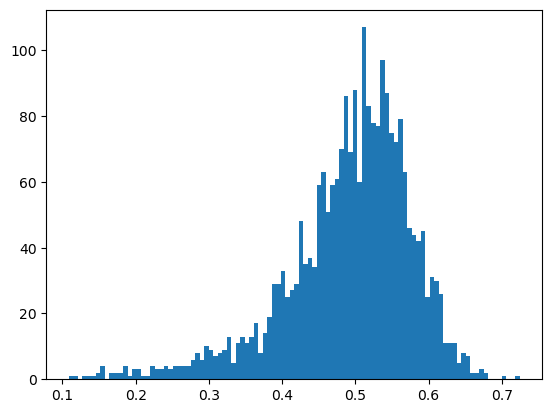

In [37]:
import matplotlib.pyplot as plt
plt.hist(submission.tm, bins=100)
plt.show()